## Import the necesary  libraries

In [2]:
from tensorflow.keras import backend as K
import tensorflow
from tensorflow.keras import initializers, layers
from tensorflow.keras.layers import Input, MaxPooling2D, Conv2D, Layer, Reshape, Lambda, Softmax
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, AveragePooling2D
from tensorflow.keras.applications import VGG16, VGG19, resnet50
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger
import tensorflow as tf

import numpy as np
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from PIL import Image
import os
import time
# import argparse
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks
from tensorflow.keras.models import  Sequential, Model

# to confusion_matrix and roc courve 
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc 

K.set_image_data_format('channels_last')

## Disable Eager Execution

In [3]:
tf.compat.v1.disable_eager_execution()

"""
https://github.com/tensorflow/tensorflow/issues/33747
with tf.device('CPU'):
    tensor2 = tf.identity(tensor1)

"""

"\nhttps://github.com/tensorflow/tensorflow/issues/33747\nwith tf.device('CPU'):\n    tensor2 = tf.identity(tensor1)\n\n"

## Load images in binary npz format from repository

In [ ]:
train_data =  np.load('/content/drive/MyDrive/npzfiles/train.npz')
valid_data =  np.load('/content/drive/MyDrive/npzfiles/valid.npz')


## Load npz files

In [ ]:
x_train = None
y_train = None
x_valid = None
y_valid = None

x_train = train_data['x_train']
y_train = train_data['y_train']
x_valid = valid_data['x_valid']
y_valid = valid_data['y_valid']

In [4]:
image_resize_height = 224
image_resize_width  = 224
channels = 3
input_shape=(image_resize_height,image_resize_height,channels)
number_of_classes = 2
batch_size = 32  # 60
EPOCHS = 40
INIT_LR = 1e-3


## Define Pretrained Net

In [5]:
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))

# base_model = VGG19(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))

58900480/58889256 [==============================] - 2s 0us/step


## Define Net

In [6]:
headModel = base_model.output
headModel = AveragePooling2D(pool_size=(2,2))(headModel)
headModel = Flatten(name='flatten')(headModel)
headModel = Dense(64, activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(1, activation='sigmoid')(headModel)
# place the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs=base_model.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in base_model.layers:
  layer.trainable = False

# compile our model
print('[INFO] compiling model...')
opt = optimizers.Adam(learning_rate=INIT_LR)  
model.compile(loss="binary_crossentropy", optimizer=opt,  metrics=["accuracy"])

model.summary()                

[INFO] compiling model...
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None,

## Define Keras Callbacks

In [ ]:
log = CSVLogger('/content/drive/MyDrive/cnnvgg16/log/log.csv', separator=",", append=False)

lr_decay = callbacks.LearningRateScheduler(schedule=lambda epoch: 0.001 * (0.9 ** epoch))
# checkpoint = ModelCheckpoint('/content/drive/MyDrive/cnnvgg16/weights-{epoch:02d}.h5', 
#                                         monitor='val_capsnet_acc',
#                                         save_best_only=True,
#                                         save_weights_only=True, 
#                                         verbose=1)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/cnnvgg16/weights-{epoch:02d}.h5', 
                                       monitor="val_loss", 
                                       mode="min",
                                       save_best_only=True, 
                                       save_weights_only=True,
                                       verbose=1)

callbacks_list = [log, checkpoint, lr_decay]


## Train the Model

In [ ]:
historyVGG16 =  model.fit(x_train, y_train,
                          batch_size=batch_size, 
                          epochs=EPOCHS,
                          validation_data=(x_valid, y_valid),
                          shuffle=True,
                          callbacks=callbacks_list)  


Train on 8809 samples, validate on 1101 samples
Epoch 1/40
8809/8809 [==============================] - ETA: 0s - loss: 0.4306 - accuracy: 0.8102

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_loss improved from inf to 0.29010, saving model to /content/drive/MyDrive/cnnvgg16/weights-01.h5
8809/8809 [==============================] - 84s 9ms/sample - loss: 0.4306 - accuracy: 0.8102 - val_loss: 0.2901 - val_accuracy: 0.8810 - lr: 0.0010
Epoch 2/40
8809/8809 [==============================] - ETA: 0s - loss: 0.3256 - accuracy: 0.8599
Epoch 00002: val_loss improved from 0.29010 to 0.25336, saving model to /content/drive/MyDrive/cnnvgg16/weights-02.h5
8809/8809 [==============================] - 46s 5ms/sample - loss: 0.3256 - accuracy: 0.8599 - val_loss: 0.2534 - val_accuracy: 0.8946 - lr: 9.0000e-04
Epoch 3/40
8809/8809 [==============================] - ETA: 0s - loss: 0.2822 - accuracy: 0.8821
Epoch 00003: val_loss improved from 0.25336 to 0.19435, saving model to /content/drive/MyDrive/cnnvgg16/weights-03.h5
8809/8809 [==============================] - 47s 5ms/sample - loss: 0.2822 - accuracy: 0.8821 - val_loss: 0.1943 - val_accuracy: 0.9155 - lr: 8.1000e-0

## Save Whole History Model

In [ ]:
# history.history
# np.save('/content/drive/MyDrive/cnnvgg16/history/history.npy',historyVGG16.history) 

## Get History Model

In [7]:

history=np.load('/content/drive/MyDrive/cnnvgg16/history/history.npy',allow_pickle='TRUE').item()

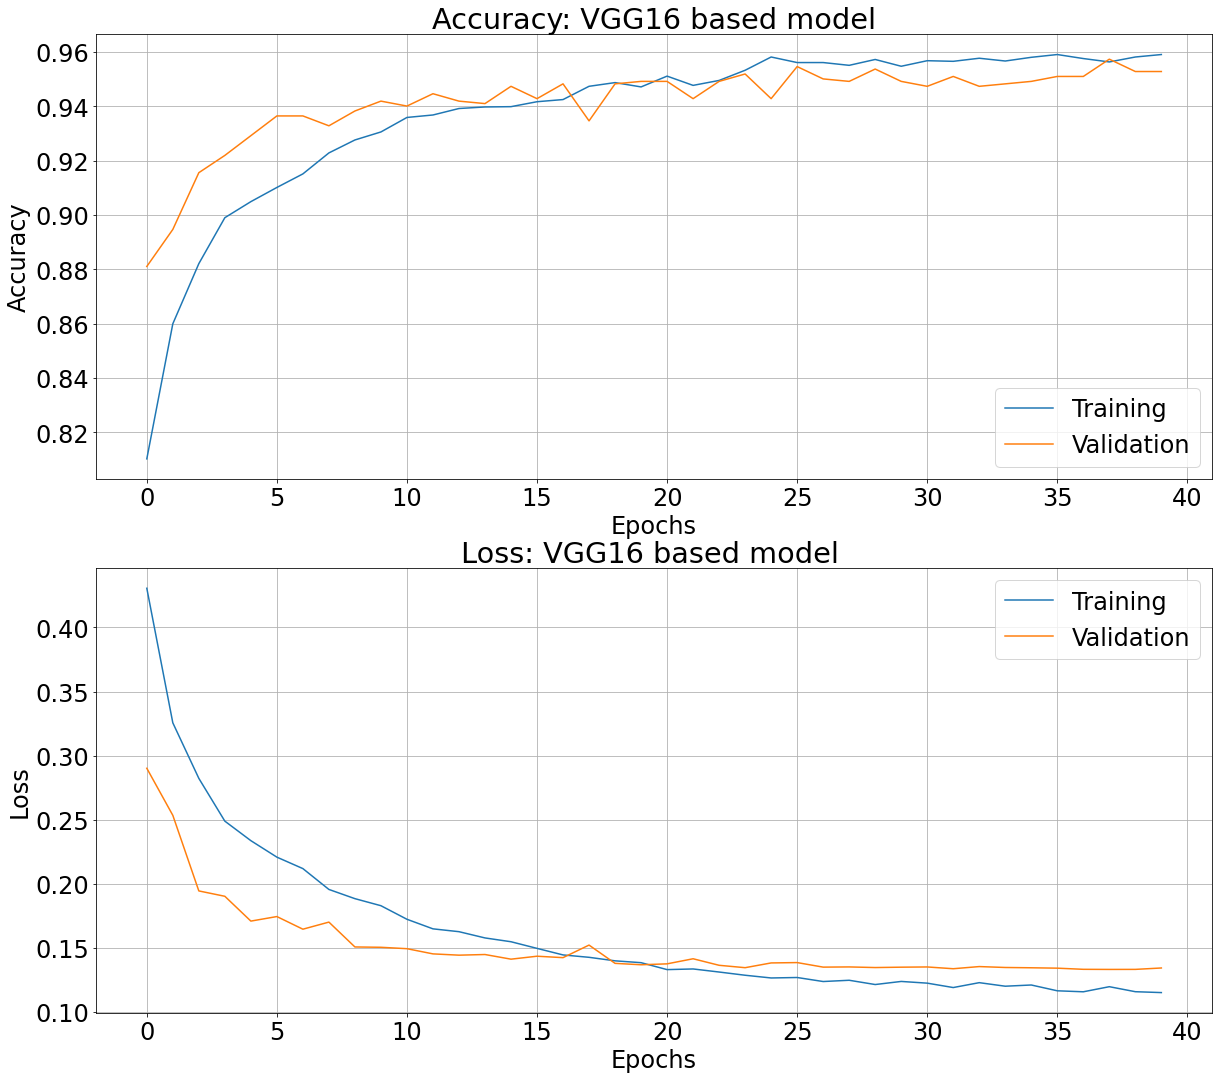

In [9]:
import matplotlib.pyplot as plt
# fig, ax = plt.subplots(1, 2, figsize=(20, 3))
fig, ax = plt.subplots(2, 1, figsize=(20,18))
ax = ax.ravel()
plt.rcParams.update({'font.size': 24})

# spanish

# titles = ['Precisión del modelo', 'Pérdida del modelo']
# ylabels = ['Precisión', 'Pérdida']
# epoch_Label = 'Épocas'
# # legend_ = ['Entrenamiento', 'Validación']

# english
titles = ['Accuracy: VGG16 based model', 'Loss: VGG16 based model ']
ylabels = ['Accuracy', 'Loss']
epoch_Label = 'Epochs'
legend_ = ['Training', 'Validation']


font_size = 24

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history[met])
    ax[i].plot(history['val_' + met])
    # ax[i].set_title('Model {}'.format(met))
    ax[i].set_title(titles[i])
    ax[i].set_xlabel(epoch_Label, fontsize=font_size)
    # ax[i].set_ylabel(met)
    ax[i].set_ylabel(ylabels[i], fontsize=font_size)
    ax[i].legend(legend_)
    ax[i].grid()
    

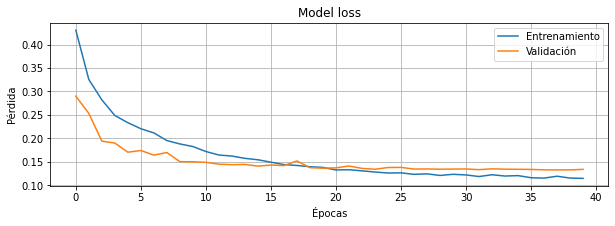

In [ ]:
plt.subplots(1, 1, figsize=(10, 3))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model {}'.format('loss'))
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend(['Entrenamiento', 'Validación'])
plt.grid(True)

## Plot graph between training and validation loss

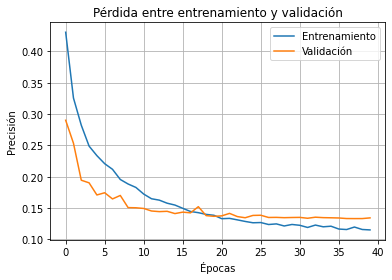

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['Entrenamiento', 'Validación'])
plt.title('Pérdida entre entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.grid(True)



## Plot graph between training and validation accuarcy

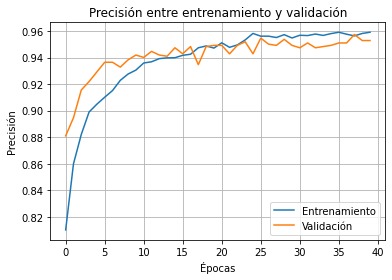

In [ ]:
#plot graph between training and validation accuarcy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.legend(['Entrenamiento', 'Validación'])
plt.title('Precisión entre entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.grid(True)

In [8]:
x_train = None
x_valid = None
y_train = None
y_valid = None

x_test = None
y_test = None

In [9]:

test_data =  np.load('/content/drive/MyDrive/npzfiles/test.npz')
x_test = test_data['x_test']
y_test = test_data['y_test']


In [10]:
model.load_weights("/content/drive/MyDrive/cnnvgg16/w/weights9sep.h5")

In [11]:
predictions = model.predict(x_test, batch_size=100)


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [12]:
ypred = [1 if x > 0.5 else 0 for x in predictions]


In [13]:
cm = confusion_matrix(y_test, ypred)
cm

array([[611,  33],
       [ 32, 426]])

In [15]:
import itertools #create iterators for effective looping 

plt.rcParams.update({'font.size': 12})

def plot_cm():
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  print('Transacciones legítimas detectadas (Verdaderos Negativos ): ', cm[0][0])
  print('Transacciones legítimas detectadas incorrectamente (Falsos Positivos): ', cm[0][1])
  print('Transacciones fraudulentas perdidas (Falsos Negativos): ', cm[1][0])
  print('Transacciones fraudulentas detectadas (Verdaderos Positivos): ', cm[1][1])
  print('Total de transacciones fraudulentas: ', np.sum(cm[1]))



def plot_roc():
    # english labels
  random_guess = 'Random guess'
  Perfect_performance = 'Perfect performance'
  fp_rate = 'False positive rate'
  tp_rate = 'True positive rate'
  title_roc = 'VGG16 based model'
  xlabel_ = 'ROC curve  (area = {:.2f} )'

  # spanish labels

  # random_guess = 'Suposición aleatoria'
  # Perfect_performance = 'Rendimiento perfecto'
  # fp_rate = 'Tasa de falsos positivos'
  # tp_rate = 'Tasa de verdaderos positivos'
  # title_roc = 'Modelo basado en VGG16'
  # xlabel_ = 'Curva ROC  (área = {:.2f} )'
  
  
  font_size = 16
  fpr, tpr, thresholds = roc_curve(y_test, predictions)
  roc_auc = auc(fpr, tpr)
  # plt.plot(fpr, tpr, lw = 2, label = 'ROC AUC: {:.2f}'.format(roc_auc))
  plt.plot(fpr, tpr, lw = 2, label = xlabel_.format(roc_auc))
  plt.plot([0, 1], [0, 1],
          linestyle = '--',
          color = (0.6, 0.6, 0.6),
          label =random_guess)
  plt.plot([0, 0, 1], [0, 1, 1],
          linestyle = ':',
          color = 'black', 
          label = Perfect_performance)
  plt.xlim([-0.05, 1.05])
  plt.ylim([-0.05, 1.05])
  plt.xlabel(fp_rate,fontsize=font_size)
  plt.ylabel(tp_rate,fontsize=font_size)
  plt.title(title_roc,fontsize=font_size)
  plt.legend(loc = "lower right")
  plt.tight_layout()
  plt.show() 


def plot_confusion_matrix(cm, classes, cmap=plt.cm.Oranges):
                       
  # english labels
  title_ = 'VGG16 based model'
  ylabel_='True label'
  xlabel_= 'Predicted label'
  

  # spanish labels
  # title_ = 'Modelo basado en VGG16'
  # ylabel_='Etiqueta vedadera'
  # xlabel_= 'Etiqueta predicha'
  
  
  print(cm)
  plt.figure(figsize=(6,6))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title_)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  

  fmt = '.2f'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j]),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

  plt.ylabel(ylabel_)
  plt.xlabel(xlabel_)
  plt.tight_layout()  

In [ ]:
plot_cm()

In [ ]:
TN = cm[1][1]
print("TN: ", TN)
FP = cm[0][1]
print("FP: ", FP)
FN = cm[1][0]
print("FN: ", FN)
TP = cm[0][0]
print("TP: ", TP)
print("******************************************************")
Accuracy = (TP+TN) / (TP+TN+FP+FN)
print("Accuracy: ", Accuracy)
Sensitivity =  TP/(TP+FN)    
print("Sensitivity: ", Sensitivity)
Specificity = TN/(TN+FP)
print("Specificity: ", Specificity)

TN:  611
FP:  33
FN:  32
TP:  426
******************************************************
Accuracy:  0.941016333938294
Sensitivity:  0.9301310043668122
Specificity:  0.9487577639751553


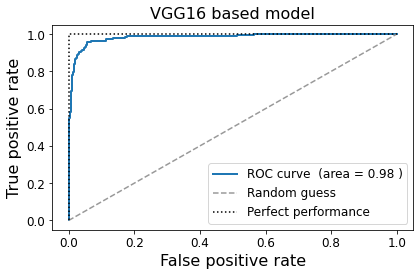

In [16]:
plot_roc()

[[611  33]
 [ 32 426]]


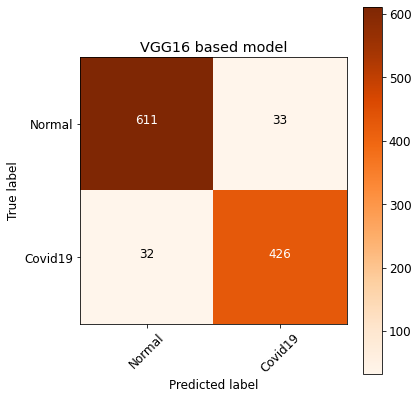

In [17]:
class_names=["Normal","Covid19"]
cm3 = confusion_matrix(y_test, ypred)
plot_confusion_matrix(cm3, classes=class_names)
              